In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(ROOT_DIR+ "/train.csv")
test_data = pd.read_csv(ROOT_DIR+ "/test.csv")
new_data = pd.read_csv(ROOT_DIR+ "/important_data.csv")

print("train 데이터: ",train_data.shape)
print("test 데이터: ",test_data.shape)

train 데이터:  (40506, 464)
test 데이터:  (17361, 465)


In [3]:
#전부 null인 칼럼 제거
cols = train_data.columns
null_list = []

for i in cols:
    if train_data[i].isna().sum() == train_data.shape[0]:
        null_list.append(i)

train_not_null = train_data.drop(columns=null_list)
print("전부 null인 칼럼 제거 후 ",train_not_null.shape)

전부 null인 칼럼 제거 후  (40506, 186)


In [4]:
# 8개의 NULL(OK) 포함 칼럼 제거
columns_with_ok = [col for col in train_not_null.columns if train_not_null[col].eq('OK').any()]
tmp = train_not_null[columns_with_ok]
additional_null = tmp.columns[tmp.isna().sum() > 0].tolist()
train_not_null.drop(columns = additional_null,inplace=True)
print("대회 정정사항 null인 칼럼 제거 후 ",train_not_null.shape)

대회 정정사항 null인 칼럼 제거 후  (40506, 178)


In [5]:
COORDINATE_column_nnull = [col for col in train_not_null.columns if 'coordinate' in col.lower()]
POSITION_columns_nnull = [col for col in train_not_null.columns if 'position' in col.lower()]

In [6]:
print(len(COORDINATE_column_nnull))
print(len(POSITION_columns_nnull))

24
48


In [7]:
# 거리 계산 함수 정의
def calculate_distances(df, threshold):
    # 거리 계산을 위한 빈 데이터프레임 생성
    distances = pd.DataFrame(index=df.index)
    distances['value'] = df['value']  # 기존 값 복사
    distances['distance'] = np.nan  # 거리 칼럼 초기화

    # 빈도수가 높은 값들을 기준으로 처리
    while not df.empty:
        # 가장 빈도수가 높은 값과 그 빈도수 선택
        most_frequent_value = df['value'].iloc[0]

        # 해당 기준값으로부터 threshold 범위 이내의 값을 처리
        df_within_threshold = df[abs(df['value'] - most_frequent_value) <= threshold]
        df_outside_threshold = df[abs(df['value'] - most_frequent_value) > threshold]

        # 기준 값과의 거리 계산
        distances.loc[df_within_threshold.index, 'distance'] = df_within_threshold['value'].apply(lambda x: abs(x - most_frequent_value))

        # 최빈값은 거리가 0이 되도록
        distances.loc[df_within_threshold.index[df_within_threshold['value'] == most_frequent_value], 'distance'] = 0
        # 범위 이내의 값 처리 후 제거
        df = df_outside_threshold

    return distances

In [8]:
# train_coordinate =train_not_null[COORDINATE_column_nnull]
# # 기준 거리 설정
# threshold = 40

# # 원본 데이터프레임의 모든 칼럼에 대해 반복
# for col in train_coordinate.columns:
#     print(f"Processing column: {col}")

#     # value_counts로부터 데이터프레임 생성
#     value_counts = train_coordinate[col].value_counts()
#     df = value_counts.reset_index()
#     df.columns = ['value', 'count']

#     # 거리 계산
#     distances = calculate_distances(df, threshold)

#     # 원본 데이터에 거리 값을 적용
#     def apply_distances(value):
#         if value in distances['value'].values:
#             return distances.loc[distances['value'] == value, 'distance'].values[0]
#         else:
#             return np.nan

#    # 새 데이터프레임 생성
#     train_coordinate_copy = train_coordinate.copy()
#     # 거리 값을 적용할 새로운 칼럼 생성
#     train_coordinate_copy[col + '_distance'] = train_coordinate_copy[col].apply(apply_distances)

#     # 원본 데이터프레임에 새로운 칼럼 추가
#     # .loc 사용하여 칼럼을 추가합니다.
#     train_coordinate.loc[:, col + '_distance'] = train_coordinate_copy[col + '_distance']

# # 결과 출력
# print(train_coordinate.head())

# 매번 돌리기 시간이 오래 걸리는 코드로 미리 데이터 파일로 만들어 두겠음
train_position = pd.read_csv("train_coordinate.csv")

# for 문을 통해 원래 데이터에 덮어씌우기
for col in COORDINATE_column_nnull:
    train_not_null[col] = train_position[f"{col}_distance"]

In [9]:
# train_position=train_not_null[POSITION_columns_nnull]
# # 기준 거리 설정
# threshold = 20
# # 원본 데이터프레임의 모든 칼럼에 대해 반복
# for col in train_position.columns:
#     print(f"Processing column: {col}")

#     # value_counts로부터 데이터프레임 생성
#     value_counts = train_position[col].value_counts()
#     df = value_counts.reset_index()
#     df.columns = ['value', 'count']

#     # 거리 계산
#     distances = calculate_distances(df, threshold)

#     # 원본 데이터에 거리 값을 적용
#     def apply_distances(value):
#         if value in distances['value'].values:
#             return distances.loc[distances['value'] == value, 'distance'].values[0]
#         else:
#             return np.nan

#    # 새 데이터프레임 생성
#     train_position_copy = train_position.copy()
#     # 거리 값을 적용할 새로운 칼럼 생성
#     train_position_copy[col + '_distance'] = train_position_copy[col].apply(apply_distances)

#     # 원본 데이터프레임에 새로운 칼럼 추가
#     # .loc 사용하여 칼럼을 추가합니다.
#     train_position.loc[:, col + '_distance'] = train_position_copy[col + '_distance']

# # 결과 출력
# print(train_position.head())

# 매번 돌리기 시간이 오래 걸리는 코드로 미리 데이터 파일로 만들어 두겠음
train_position = pd.read_csv("train_position.csv")
# for 문을 통해 원래 데이터에 덮어씌우기
for col in POSITION_columns_nnull:
    train_not_null[col] = train_position[f"{col}_distance"]

In [10]:
# test 데이터에도 같은 과정을 진행해야한다

In [11]:
#하나의 값만 가지는 칼럼 제거
cols2 = train_not_null.columns
unique_cols = []

for i in cols2:
    if train_not_null[i].nunique() == 1:
        unique_cols.append(i)

train_final = train_not_null.drop(columns = unique_cols )
print("하나의 값만 가지는 칼럼 제거 후 ",train_final.shape)

하나의 값만 가지는 칼럼 제거 후  (40506, 114)


In [12]:
# 인코딩 후 중복을 칼럼을 제거합니다.
train_drop_dup= train_final.copy()

for col in train_drop_dup.columns:
    order = train_drop_dup[col].value_counts().index.tolist()
    order_map = {value: idx for idx, value in enumerate(order)}
    tmp = pd.Categorical(train_drop_dup[col], categories=order, ordered=True)
    train_drop_dup[col] = tmp.codes

list_dup = train_drop_dup.columns[train_drop_dup.T.duplicated(keep=False)]
duplicate_rows = train_drop_dup.T

train_drop_dup = train_drop_dup.T.drop_duplicates().T
cols_drop_dup = train_drop_dup.columns

train_final = train_final[cols_drop_dup]
print("인코딩 중복 제거 후 : ",train_final.shape)

인코딩 중복 제거 후 :  (40506, 90)


In [13]:
# null 제거인데 이미 위에서 진행햇음
a= train_final.isnull().sum() > 0
a= a.index
null_list = a[train_final.isnull().sum() > 0]

train_final = train_final.drop(columns=null_list)
print("null 칼럼 제거 후 : ",train_final.shape)

null 칼럼 제거 후 :  (40506, 90)


In [14]:
COORDINATE_columns = [col for col in train_final.columns if 'coordinate' in col.lower()]
POSITION_columns = [col for col in train_final.columns if 'position' in col.lower()]

In [15]:
# 지금까지 칼럼을 전처리 하는 방법은 끝이고 이제 이어서 각 데이터 칼럼 값을 바꾸는 과정을 진행할 예정으로 train,test 모두 처리해주어야한다.

In [16]:
test_data = pd.read_csv("data/test.csv")
test_not_null = test_data[train_final.columns]
test_not_null.shape

(17361, 90)

In [17]:
# 우선 앞서 진행한 coordinate , position 전처리를 해준다.
# (사실 train , test concat 한다음에 진행했어야하는데 시각화랑 이것 저것 이미 진행해서 test데이터 에서만 동일하게 진행하겠음)

# test_coordinate =test_data[COORDINATE_column_nnull]
# # 기준 거리 설정
# threshold = 40

# # 원본 데이터프레임의 모든 칼럼에 대해 반복
# for col in test_coordinate.columns:
#     print(f"Processing column: {col}")

#     # value_counts로부터 데이터프레임 생성
#     value_counts = test_coordinate[col].value_counts()
#     df = value_counts.reset_index()
#     df.columns = ['value', 'count']

#     # 거리 계산
#     distances = calculate_distances(df, threshold)

#     # 원본 데이터에 거리 값을 적용
#     def apply_distances(value):
#         if value in distances['value'].values:
#             return distances.loc[distances['value'] == value, 'distance'].values[0]
#         else:
#             return np.nan

#    # 새 데이터프레임 생성
#     test_coordinate_copy = test_coordinate.copy()
#     # 거리 값을 적용할 새로운 칼럼 생성
#     test_coordinate_copy[col + '_distance'] = test_coordinate_copy[col].apply(apply_distances)

#     # 원본 데이터프레임에 새로운 칼럼 추가
#     # .loc 사용하여 칼럼을 추가합니다.
#     test_coordinate.loc[:, col + '_distance'] = test_coordinate_copy[col + '_distance']

# # 결과 출력
# print(test_coordinate.head())

# 매번 돌리기 시간이 오래 걸리는 코드로 미리 데이터 파일로 만들어 두겠음
test_coordinate = pd.read_csv("test_coordinate.csv")
for col in COORDINATE_columns:
    test_not_null[col] = test_coordinate[f"{col}_distance"]


/tmp/ipykernel_747/3504433409.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_not_null[col] = test_coordinate[f"{col}_distance"]


In [18]:
test_position=test_data[POSITION_columns_nnull]
# 기준 거리 설정
threshold = 20
# 원본 데이터프레임의 모든 칼럼에 대해 반복

# for col in test_position.columns:
#     print(f"Processing column: {col}")

#     # value_counts로부터 데이터프레임 생성
#     value_counts = test_position[col].value_counts()
#     df = value_counts.reset_index()
#     df.columns = ['value', 'count']

#     # 거리 계산
#     distances = calculate_distances(df, threshold)

#     # 원본 데이터에 거리 값을 적용
#     def apply_distances(value):
#         if value in distances['value'].values:
#             return distances.loc[distances['value'] == value, 'distance'].values[0]
#         else:
#             return np.nan

#    # 새 데이터프레임 생성
#     test_position_copy = test_position.copy()
#     # 거리 값을 적용할 새로운 칼럼 생성
#     test_position_copy[col + '_distance'] = test_position_copy[col].apply(apply_distances)

#     # 원본 데이터프레임에 새로운 칼럼 추가
#     # .loc 사용하여 칼럼을 추가합니다.
#     test_position.loc[:, col + '_distance'] = test_position_copy[col + '_distance']

# # 결과 출력
# print(test_position.head())

# 매번 돌리기 시간이 오래 걸리는 코드로 미리 데이터 파일로 만들어 두겠음
test_coordinate = pd.read_csv("test_position.csv")
for col in POSITION_columns:
    test_not_null[col] = test_coordinate[f"{col}_distance"]

/tmp/ipykernel_747/619731773.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_not_null[col] = test_coordinate[f"{col}_distance"]


In [19]:
test_data = test_not_null.copy()

In [20]:
new_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,...,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD Standby Position X Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334501,3H1XD883-1,70,10,9.7,4.9,9.7,0.67,0.34,...,458.0,427.9,243.7,270.0,19.7,8.0,195,1,0,Normal
1,Dam dispenser #1,AJX75334501,3H1XE851-1,70,10,9.7,4.9,9.7,0.67,0.34,...,458.0,427.9,243.7,270.0,19.2,6.0,147,1,0,Normal
2,Dam dispenser #1,AJX75334501,3H1XE854-1,70,10,9.7,5.0,9.7,0.67,0.35,...,458.0,427.9,243.7,270.0,19.2,2.0,210,1,0,Normal
3,Dam dispenser #1,AJX75334501,3H1X3338-1,70,10,9.7,4.9,9.7,0.67,0.34,...,458.0,427.9,243.7,270.0,19.8,3.0,265,1,0,Normal
4,Dam dispenser #1,AJX75334501,3H1XC258-1,70,10,9.7,4.9,9.7,0.67,0.34,...,458.0,427.9,243.7,270.0,19.1,6.0,73,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5402,Dam dispenser #1,AJX75334501,3G1XA481-1,70,10,9.6,3.9,9.6,0.67,0.27,...,458.0,427.9,243.7,270.0,19.0,6.0,277,1,0,Normal
5403,Dam dispenser #1,AJX75334501,3G1XA502-1,70,10,9.7,3.9,9.6,0.67,0.27,...,458.0,427.9,243.7,270.0,19.0,5.0,155,1,0,Normal
5404,Dam dispenser #1,AJX75334501,3G1XC619-2,70,10,9.7,4.9,9.7,0.67,0.34,...,458.0,427.9,243.7,270.0,19.0,1.0,0,1,0,Normal
5405,Dam dispenser #1,AJX75334501,3G1XC496-2,70,10,9.6,4.9,9.7,0.67,0.34,...,458.0,427.9,243.7,270.0,19.0,7.0,232,1,0,Normal


In [21]:
train_bins = train_final.copy()
test_bins = test_data.copy()
new_final = new_data.copy()
new_bins = new_final.copy()

In [22]:
new_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,...,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD Standby Position X Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334501,3H1XD883-1,70,10,9.7,4.9,9.7,0.67,0.34,...,458.0,427.9,243.7,270.0,19.7,8.0,195,1,0,Normal
1,Dam dispenser #1,AJX75334501,3H1XE851-1,70,10,9.7,4.9,9.7,0.67,0.34,...,458.0,427.9,243.7,270.0,19.2,6.0,147,1,0,Normal
2,Dam dispenser #1,AJX75334501,3H1XE854-1,70,10,9.7,5.0,9.7,0.67,0.35,...,458.0,427.9,243.7,270.0,19.2,2.0,210,1,0,Normal
3,Dam dispenser #1,AJX75334501,3H1X3338-1,70,10,9.7,4.9,9.7,0.67,0.34,...,458.0,427.9,243.7,270.0,19.8,3.0,265,1,0,Normal
4,Dam dispenser #1,AJX75334501,3H1XC258-1,70,10,9.7,4.9,9.7,0.67,0.34,...,458.0,427.9,243.7,270.0,19.1,6.0,73,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5402,Dam dispenser #1,AJX75334501,3G1XA481-1,70,10,9.6,3.9,9.6,0.67,0.27,...,458.0,427.9,243.7,270.0,19.0,6.0,277,1,0,Normal
5403,Dam dispenser #1,AJX75334501,3G1XA502-1,70,10,9.7,3.9,9.6,0.67,0.27,...,458.0,427.9,243.7,270.0,19.0,5.0,155,1,0,Normal
5404,Dam dispenser #1,AJX75334501,3G1XC619-2,70,10,9.7,4.9,9.7,0.67,0.34,...,458.0,427.9,243.7,270.0,19.0,1.0,0,1,0,Normal
5405,Dam dispenser #1,AJX75334501,3G1XC496-2,70,10,9.6,4.9,9.7,0.67,0.34,...,458.0,427.9,243.7,270.0,19.0,7.0,232,1,0,Normal


In [23]:
Time_columns = [col for col in train_final.columns if 'Time' in col]

train_bins[Time_columns[0]] = train_final[Time_columns[0]] / train_final[Time_columns[3]]
train_bins[Time_columns[1]] = train_final[Time_columns[1]] / train_final[Time_columns[3]]
train_bins[Time_columns[2]] = train_final[Time_columns[2]] / train_final[Time_columns[3]]

test_bins[Time_columns[0]] = test_data[Time_columns[0]] / test_data[Time_columns[3]]
test_bins[Time_columns[1]] = test_data[Time_columns[1]] / test_data[Time_columns[3]]
test_bins[Time_columns[2]] = test_data[Time_columns[2]] / test_data[Time_columns[3]]

new_bins[Time_columns[0]] = new_final[Time_columns[0]] / new_final[Time_columns[3]]
new_bins[Time_columns[1]] = new_final[Time_columns[1]] / new_final[Time_columns[3]]
new_bins[Time_columns[2]] = new_final[Time_columns[2]] / new_final[Time_columns[3]]


In [24]:
time_columns = list(set([col for col in train_final.columns if 'time' in col.lower()]) - set(Time_columns))
train_final[time_columns].nunique()

Machine Tact time Collect Result_Dam                     266
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam       29
Machine Tact time Collect Result_Fill2                    42
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam       19
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1     16
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1     16
Machine Tact time Collect Result_Fill1                   194
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam       20
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1     24
dtype: int64

In [25]:
#time_columns 구간화 하는것이 성능이 더 잘나왔음 구간화 이후 타겟 인코딩 순서가 있으므로 Ordinal Encoding은 어떨까?
for col in time_columns:
    # 훈련 데이터와 테스트 데이터를 합쳐서 두 데이터셋 모두의 범위를 포함하도록 설정
    combined_data = pd.concat([train_final[col], test_data[col]])

    # 합쳐진 데이터로부터 Sturges' 규칙을 사용하여 구간 경계값 계산
    bins = np.histogram_bin_edges(combined_data, bins='sturges')

    # 구간 중심값 계산
    bin_centers = [(bin_edge_left + bin_edge_right) / 2 for bin_edge_left, bin_edge_right in zip(bins[:-1], bins[1:])]

    # 훈련 데이터의 구간화 (구간을 왼쪽, 오른쪽 경계 모두 포함하여 설정)
    binned_train = pd.cut(train_final[col], bins=bins, include_lowest=True)
    bin_mapping = dict(zip(binned_train.cat.categories, bin_centers))
    train_bins[col] = binned_train.map(bin_mapping)
    
    #새로운 데이터도 구간화
    binned_new = pd.cut(new_final[col], bins=bins, include_lowest=True)
    bin_mapping = dict(zip(binned_new.cat.categories, bin_centers))
    new_bins[col] = binned_new.map(bin_mapping)    

    # 테스트 데이터의 구간화
    binned_test = pd.cut(test_data[col], bins=bins, include_lowest=True)
    test_bins[col] = binned_test.map(bin_mapping)

    # 결측치 처리: 구간 밖의 값들 처리
    # 각 구간 중심값 계산
    first_bin_center = bin_centers[0]
    last_bin_center = bin_centers[-1]

    # 훈련 데이터에서 구간 경계를 벗어나는 값 처리
    train_bins.loc[train_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    train_bins.loc[train_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

    # 새로운 데이터에서 구간 경계를 벗어나는 값 처리
    new_bins.loc[new_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    new_bins.loc[new_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값
    
    # 테스트 데이터에서 구간 경계를 벗어나는 값 처리
    test_bins.loc[test_data[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    test_bins.loc[test_data[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값


In [26]:
# 'Machine Tact time'이 포함된 열 이름 리스트 생성
Machine_Tact_time_columns = [col for col in train_final.columns if 'Machine Tact time' in col]

for col in Machine_Tact_time_columns:
    # 훈련 데이터와 테스트 데이터를 합쳐서 두 데이터셋 모두의 범위를 포함하도록 설정
    combined_data = pd.concat([train_final[col], test_data[col]])

    # 합쳐진 데이터로부터 Sturges' 규칙을 사용하여 구간 경계값 계산
    bins = np.histogram_bin_edges(combined_data, bins='sturges')

    # 구간 중심값 계산
    bin_centers = [(bin_edge_left + bin_edge_right) / 2 for bin_edge_left, bin_edge_right in zip(bins[:-1], bins[1:])]

    # 훈련 데이터의 구간화 (구간을 왼쪽, 오른쪽 경계 모두 포함하여 설정)
    binned_train = pd.cut(train_final[col], bins=bins, include_lowest=True)
    bin_mapping = dict(zip(binned_train.cat.categories, bin_centers))
    train_bins[col] = binned_train.map(bin_mapping)

    # 새로운 데이터의 구간화 (구간을 왼쪽, 오른쪽 경계 모두 포함하여 설정)
    binned_new = pd.cut(new_final[col], bins=bins, include_lowest=True)
    bin_mapping = dict(zip(binned_new.cat.categories, bin_centers))
    new_bins[col] = binned_new.map(bin_mapping)    
    
    # 테스트 데이터의 구간화
    binned_test = pd.cut(test_data[col], bins=bins, include_lowest=True)
    test_bins[col] = binned_test.map(bin_mapping)

    # 결측치 처리: 구간 밖의 값들 처리
    # 각 구간 중심값 계산
    first_bin_center = bin_centers[0]
    last_bin_center = bin_centers[-1]

    # 훈련 데이터에서 구간 경계를 벗어나는 값 처리
    train_bins.loc[train_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    train_bins.loc[train_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

    # 새로운 데이터에서 구간 경계를 벗어나는 값 처리
    new_bins.loc[new_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    new_bins.loc[new_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값
    
    
    # 테스트 데이터에서 구간 경계를 벗어나는 값 처리
    test_bins.loc[test_data[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    test_bins.loc[test_data[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값


In [27]:
#Pallet 칼럼들 전처리 (3개의 칼럼)
Pallet_columns = [col for col in train_final.columns if 'pallet' in col.lower()]

#Qty 칼럼들 전처리 (3개의 칼럼)
#Qty 칼럼들 전부 구간화 하는 방법은 폐기
Qty_columns = [col for col in train_final.columns if 'qty' in col.lower()]

#Receip 칼럼들 전처리 (3개의 칼럼)
#Receip 칼럼들 전부 구간화 하는 방법은 폐기
Receip_columns = [col for col in train_final.columns if 'receip' in col.lower()]
train_final[Receip_columns]

print("Pallet_columns:" ,len(Pallet_columns))
print("Qty_columns:" ,len(Qty_columns))
print("Receip_columns:" ,len(Receip_columns))
# 총 9개의 칼럼은 중요도가 높아 잘 학습할 수 있도록 처리해야함

Pallet_columns: 3
Qty_columns: 3
Receip_columns: 3


In [28]:
#값들을 확인해보니 거의다 같지만 몇몇 행들만 값이 달랐음 다름을 학습시키려함

train_bins[Qty_columns[2]] = train_bins[Qty_columns[1]] == train_bins[Qty_columns[2]]
train_bins[Qty_columns[1]] = train_bins[Qty_columns[0]] == train_bins[Qty_columns[1]]

train_bins[Receip_columns[2]] = train_bins[Receip_columns[1]] == train_bins[Receip_columns[2]]
train_bins[Receip_columns[1]] = train_bins[Receip_columns[0]] == train_bins[Receip_columns[1]]

new_bins[Qty_columns[2]] = new_bins[Qty_columns[1]] == new_bins[Qty_columns[2]]
new_bins[Qty_columns[1]] = new_bins[Qty_columns[0]] == new_bins[Qty_columns[1]]

new_bins[Receip_columns[2]] = new_bins[Receip_columns[1]] == new_bins[Receip_columns[2]]
new_bins[Receip_columns[1]] = new_bins[Receip_columns[0]] == new_bins[Receip_columns[1]]

test_bins[Qty_columns[2]] = test_bins[Qty_columns[1]] == test_bins[Qty_columns[2]]
test_bins[Qty_columns[1]] = test_bins[Qty_columns[0]] == test_bins[Qty_columns[1]]

test_bins[Receip_columns[2]] = test_bins[Receip_columns[1]] == test_bins[Receip_columns[2]]
test_bins[Receip_columns[1]] = test_bins[Receip_columns[0]] == test_bins[Receip_columns[1]]

In [29]:
# #Qty_columns 구간화
# col = Qty_columns[0]
# combined_data = pd.concat([train_final[col], test_data[col]])

# bins = np.histogram_bin_edges(combined_data, bins='sturges')

# bin_centers = [(bin_edge_left + bin_edge_right) / 2 for bin_edge_left, bin_edge_right in zip(bins[:-1], bins[1:])]

# binned_train = pd.cut(train_final[col], bins=bins, include_lowest=True)
# bin_mapping = dict(zip(binned_train.cat.categories, bin_centers))
# train_bins[col] = binned_train.map(bin_mapping)

# binned_test = pd.cut(test_data[col], bins=bins, include_lowest=True)
# test_bins[col] = binned_test.map(bin_mapping)

# # 각 구간 중심값 계산
# first_bin_center = bin_centers[0]
# last_bin_center = bin_centers[-1]

# # 훈련 데이터에서 구간 경계를 벗어나는 값 처리
# train_bins.loc[train_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
# train_bins.loc[train_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

# # 테스트 데이터에서 구간 경계를 벗어나는 값 처리
# test_bins.loc[test_data[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
# test_bins.loc[test_data[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

In [30]:
# #Receip_columns 구간화
# col=Receip_columns[0]
# combined_data = pd.concat([train_final[col], test_data[col]])

# bins = np.histogram_bin_edges(combined_data, bins='sturges')

# bin_centers = [(bin_edge_left + bin_edge_right) / 2 for bin_edge_left, bin_edge_right in zip(bins[:-1], bins[1:])]

# binned_train = pd.cut(train_final[col], bins=bins, include_lowest=True)
# bin_mapping = dict(zip(binned_train.cat.categories, bin_centers))
# train_bins[col] = binned_train.map(bin_mapping)

# binned_test = pd.cut(test_data[col], bins=bins, include_lowest=True)
# test_bins[col] = binned_test.map(bin_mapping)

# # 각 구간 중심값 계산
# first_bin_center = bin_centers[0]
# last_bin_center = bin_centers[-1]

# # 훈련 데이터에서 구간 경계를 벗어나는 값 처리
# train_bins.loc[train_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
# train_bins.loc[train_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

# # 테스트 데이터에서 구간 경계를 벗어나는 값 처리
# test_bins.loc[test_data[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
# test_bins.loc[test_data[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

In [31]:
# #Pallet_ID ID의 의미라면 구간화는 진행하지 않고 카테고리로 변환해야할듯
for col in Pallet_columns:
    train_bins[col] = train_bins[col].astype('category')
    new_bins[col] = new_bins[col].astype('category')

In [32]:
COORDINATE_columns = [col for col in train_final.columns if 'coordinate' in col.lower()]
POSITION_columns = [col for col in train_final.columns if 'position' in col.lower()]

In [33]:
integration_columns = time_columns+Pallet_columns+Qty_columns+Receip_columns+COORDINATE_columns+POSITION_columns
remain_columns= list(set(train_final.columns.tolist()) - set(integration_columns))

print("지금까지의 칼럼을 제외한 칼럼",len(remain_columns))

train_remain =train_final[remain_columns]
new_remain =new_final[remain_columns]

지금까지의 칼럼을 제외한 칼럼 44


In [34]:
Dispense_Volume_columns = [col for col in train_remain.columns if 'Dispense Volume' in col]
print("Dispense_Volume_columns의 개수" ,len(Dispense_Volume_columns))

Distance_Speed_columns = [col for col in train_remain.columns if 'Distance Speed' in col]
print("Distance_Speed_columns 개수" ,len(Distance_Speed_columns))

Distance_Speed_Line_columns =[col for col in Distance_Speed_columns if 'Line' in col]
Distance_Speed_Circle_columns =[col for col in Distance_Speed_columns if 'Circle' in col]

DISCHARGED_SPEED_columns = [col for col in train_remain.columns if 'DISCHARGED SPEED' in col]
print("DISCHARGED_SPEED_columns 개수" ,len(DISCHARGED_SPEED_columns))

THICKNESS_columns = [col for col in train_remain.columns if 'THICKNESS' in col]
print("THICKNESS_columns 개수" ,len(THICKNESS_columns))

Pressure_columns= [col for col in train_remain.columns if 'Pressure' in col]
print("Pressure_columns 개수" ,len(Pressure_columns))

WorkMode_columns= [col for col in train_remain.columns if 'WorkMode' in col]
print("WorkMode_columns 개수" ,len(WorkMode_columns))

CURE_SPEED_columns= [col for col in train_remain.columns if 'CURE SPEED' in col]
print("CURE_SPEED_columns 개수" ,len(CURE_SPEED_columns))

list_binary = train_remain.columns[train_remain.nunique() ==2].tolist()
print("list_binary 개수" ,len(list_binary))

q= Dispense_Volume_columns + Distance_Speed_columns + DISCHARGED_SPEED_columns+THICKNESS_columns+Pressure_columns +WorkMode_columns+CURE_SPEED_columns +list_binary

train_remain2 = train_remain[list(set(train_remain.columns) - set(q))]
train_remain2.nunique()

new_remain2 = new_remain[list(set(new_remain.columns) - set(q))]
new_remain2.nunique()

Dispense_Volume_columns의 개수 4
Distance_Speed_columns 개수 15
DISCHARGED_SPEED_columns 개수 2
THICKNESS_columns 개수 3
Pressure_columns 개수 6
WorkMode_columns 개수 3
CURE_SPEED_columns 개수 2
list_binary 개수 5


Chamber Temp. Collect Result_AutoClave     20
Chamber Temp. Unit Time_AutoClave          13
Workorder_Dam                             203
Model.Suffix_Dam                            4
dtype: int64

*   Dispense_Volume_columns:quantile 4개로 구간화
*   Distance_Speed_columns:quantile 5개로 구간화
*   DISCHARGED_SPEED_columns:sturges구간화
*   THICKNESS_columns:sturges구간화
*   Pressure_columns:sturges구간화
*   WorkMode_columns:카테고리
*   CURE_SPEED_columns:sturges구간화
*   list_binary:이진화

In [35]:
for col in Dispense_Volume_columns:
    # 분위수 구간화
    quantile_bins = pd.qcut(train_final[col], q=4, duplicates='drop') #4분위 구간화
    quantile_bins_new = pd.qcut(new_final[col], q=4, duplicates='drop') #4분위 구간화
    
    # 각 구간의 최빈값 계산
    bin_modes = {}
    bin_edges = quantile_bins.cat.categories
    for bin_label in bin_edges:
        bin_data = train_final[col][quantile_bins == bin_label]
        bin_modes[bin_label] = bin_data.mode().values[0]  # 최빈값
        
    bin_modes_new = {}
    bin_edges_new = quantile_bins_new.cat.categories
    for bin_label in bin_edges_new:
        bin_data_new = new_final[col][quantile_bins_new == bin_label]
        bin_modes_new[bin_label] = bin_data_new.mode().values[0]  # 최빈값

    # 훈련 데이터의 구간화 및 최빈값 매핑
    binned_train = pd.cut(train_final[col], bins=bin_edges, include_lowest=True)
    train_bins[col] = binned_train.map(bin_modes)

    # 새로운 데이터의 구간화 및 최빈값 매핑
    binned_new = pd.cut(new_final[col], bins=bin_edges_new, include_lowest=True)
    new_bins[col] = binned_new.map(bin_modes)
    
    # 테스트 데이터의 구간화 및 최빈값 매핑
    binned_test = pd.cut(test_data[col], bins=bin_edges, include_lowest=True)
    test_bins[col] = binned_test.map(bin_modes)

    # 결측치 처리: 구간 밖의 값들 처리
    first_bin_mode = bin_modes[list(bin_modes.keys())[0]]
    last_bin_mode = bin_modes[list(bin_modes.keys())[-1]]

    # 훈련 데이터에서 구간 경계를 벗어나는 값 처리
    train_bins.loc[train_final[col] < bin_edges[0].left, col] = first_bin_mode  # 처음 구간보다 작은 값
    train_bins.loc[train_final[col] > bin_edges[-1].right, col] = last_bin_mode  # 마지막 구간보다 큰 값

    new_bins.loc[new_final[col] < bin_edges_new[0].left, col] = first_bin_mode  # 처음 구간보다 작은 값
    new_bins.loc[new_final[col] > bin_edges_new[-1].right, col] = last_bin_mode  # 마지막 구간보다 큰 값
    
    # 테스트 데이터에서 구간 경계를 벗어나는 값 처리
    test_bins.loc[test_data[col] < bin_edges[0].left, col] = first_bin_mode  # 처음 구간보다 작은 값
    test_bins.loc[test_data[col] > bin_edges[-1].right, col] = last_bin_mode  # 마지막 구간보다 큰 값

In [36]:
for col in Distance_Speed_columns:
    # 분위수 구간화
    # 분위수 구간화
    quantile_bins = pd.qcut(train_final[col], q=4, duplicates='drop') #4분위 구간화
    quantile_bins_new = pd.qcut(new_final[col], q=4, duplicates='drop') #4분위 구간화
    
    # 각 구간의 최빈값 계산
    bin_modes = {}
    bin_edges = quantile_bins.cat.categories
    for bin_label in bin_edges:
        bin_data = train_final[col][quantile_bins == bin_label]
        bin_modes[bin_label] = bin_data.mode().values[0]  # 최빈값
        
    bin_modes_new = {}
    bin_edges_new = quantile_bins_new.cat.categories
    for bin_label in bin_edges_new:
        bin_data_new = new_final[col][quantile_bins_new == bin_label]
        bin_modes_new[bin_label] = bin_data_new.mode().values[0]  # 최빈값

    # 훈련 데이터의 구간화 및 최빈값 매핑
    binned_train = pd.cut(train_final[col], bins=bin_edges, include_lowest=True)
    train_bins[col] = binned_train.map(bin_modes)

    # 새로운 데이터의 구간화 및 최빈값 매핑
    binned_new = pd.cut(new_final[col], bins=bin_edges_new, include_lowest=True)
    new_bins[col] = binned_new.map(bin_modes)
    
    # 테스트 데이터의 구간화 및 최빈값 매핑
    binned_test = pd.cut(test_data[col], bins=bin_edges, include_lowest=True)
    test_bins[col] = binned_test.map(bin_modes)

    # 결측치 처리: 구간 밖의 값들 처리
    first_bin_mode = bin_modes[list(bin_modes.keys())[0]]
    last_bin_mode = bin_modes[list(bin_modes.keys())[-1]]

    # 훈련 데이터에서 구간 경계를 벗어나는 값 처리
    train_bins.loc[train_final[col] < bin_edges[0].left, col] = first_bin_mode  # 처음 구간보다 작은 값
    train_bins.loc[train_final[col] > bin_edges[-1].right, col] = last_bin_mode  # 마지막 구간보다 큰 값

    new_bins.loc[new_final[col] < bin_edges_new[0].left, col] = first_bin_mode  # 처음 구간보다 작은 값
    new_bins.loc[new_final[col] > bin_edges_new[-1].right, col] = last_bin_mode  # 마지막 구간보다 큰 값
    
    # 테스트 데이터에서 구간 경계를 벗어나는 값 처리
    test_bins.loc[test_data[col] < bin_edges[0].left, col] = first_bin_mode  # 처음 구간보다 작은 값
    test_bins.loc[test_data[col] > bin_edges[-1].right, col] = last_bin_mode  # 마지막 구간보다 큰 값

In [37]:
for col in DISCHARGED_SPEED_columns:
    # 훈련 데이터와 테스트 데이터를 합쳐서 두 데이터셋 모두의 범위를 포함하도록 설정
    combined_data = pd.concat([train_final[col], test_data[col]])

    # 합쳐진 데이터로부터 Sturges' 규칙을 사용하여 구간 경계값 계산
    bins = np.histogram_bin_edges(combined_data, bins='sturges')

    # 구간 중심값 계산
    bin_centers = [(bin_edge_left + bin_edge_right) / 2 for bin_edge_left, bin_edge_right in zip(bins[:-1], bins[1:])]

    # 훈련 데이터의 구간화 (구간을 왼쪽, 오른쪽 경계 모두 포함하여 설정)
    binned_train = pd.cut(train_final[col], bins=bins, include_lowest=True)
    bin_mapping = dict(zip(binned_train.cat.categories, bin_centers))
    train_bins[col] = binned_train.map(bin_mapping)
    
    # 새로운 데이터의 구간화 (구간을 왼쪽, 오른쪽 경계 모두 포함하여 설정)
    binned_new = pd.cut(new_final[col], bins=bins, include_lowest=True)
    bin_mapping_new = dict(zip(binned_new.cat.categories, bin_centers))
    new_bins[col] = binned_new.map(bin_mapping_new)

    # 테스트 데이터의 구간화
    binned_test = pd.cut(test_data[col], bins=bins, include_lowest=True)
    test_bins[col] = binned_test.map(bin_mapping)

    # 결측치 처리: 구간 밖의 값들 처리
    # 각 구간 중심값 계산
    first_bin_center = bin_centers[0]
    last_bin_center = bin_centers[-1]

    # 훈련 데이터에서 구간 경계를 벗어나는 값 처리
    train_bins.loc[train_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    train_bins.loc[train_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

    
    # 새로운 데이터에서 구간 경계를 벗어나는 값 처리
    new_bins.loc[new_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    new_bins.loc[new_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

    # 테스트 데이터에서 구간 경계를 벗어나는 값 처리
    test_bins.loc[test_data[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    test_bins.loc[test_data[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값


In [38]:
for col in THICKNESS_columns:
    # 훈련 데이터와 테스트 데이터를 합쳐서 두 데이터셋 모두의 범위를 포함하도록 설정
    combined_data = pd.concat([train_final[col], test_data[col]])

    # 합쳐진 데이터로부터 Sturges' 규칙을 사용하여 구간 경계값 계산
    bins = np.histogram_bin_edges(combined_data, bins='sturges')

    # 구간 중심값 계산
    bin_centers = [(bin_edge_left + bin_edge_right) / 2 for bin_edge_left, bin_edge_right in zip(bins[:-1], bins[1:])]

    # 훈련 데이터의 구간화 (구간을 왼쪽, 오른쪽 경계 모두 포함하여 설정)
    binned_train = pd.cut(train_final[col], bins=bins, include_lowest=True)
    bin_mapping = dict(zip(binned_train.cat.categories, bin_centers))
    train_bins[col] = binned_train.map(bin_mapping)
    
    # 새로운 데이터의 구간화 (구간을 왼쪽, 오른쪽 경계 모두 포함하여 설정)
    binned_new = pd.cut(new_final[col], bins=bins, include_lowest=True)
    bin_mapping_new = dict(zip(binned_new.cat.categories, bin_centers))
    new_bins[col] = binned_new.map(bin_mapping_new)

    # 테스트 데이터의 구간화
    binned_test = pd.cut(test_data[col], bins=bins, include_lowest=True)
    test_bins[col] = binned_test.map(bin_mapping)

    # 결측치 처리: 구간 밖의 값들 처리
    # 각 구간 중심값 계산
    first_bin_center = bin_centers[0]
    last_bin_center = bin_centers[-1]

    # 훈련 데이터에서 구간 경계를 벗어나는 값 처리
    train_bins.loc[train_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    train_bins.loc[train_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

    
    # 새로운 데이터에서 구간 경계를 벗어나는 값 처리
    new_bins.loc[new_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    new_bins.loc[new_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

    # 테스트 데이터에서 구간 경계를 벗어나는 값 처리
    test_bins.loc[test_data[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    test_bins.loc[test_data[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값


In [39]:
for col in Pressure_columns:
    # 훈련 데이터와 테스트 데이터를 합쳐서 두 데이터셋 모두의 범위를 포함하도록 설정
    combined_data = pd.concat([train_final[col], test_data[col]])

    # 합쳐진 데이터로부터 Sturges' 규칙을 사용하여 구간 경계값 계산
    bins = np.histogram_bin_edges(combined_data, bins='sturges')

    # 구간 중심값 계산
    bin_centers = [(bin_edge_left + bin_edge_right) / 2 for bin_edge_left, bin_edge_right in zip(bins[:-1], bins[1:])]

    # 훈련 데이터의 구간화 (구간을 왼쪽, 오른쪽 경계 모두 포함하여 설정)
    binned_train = pd.cut(train_final[col], bins=bins, include_lowest=True)
    bin_mapping = dict(zip(binned_train.cat.categories, bin_centers))
    train_bins[col] = binned_train.map(bin_mapping)
    
    # 새로운 데이터의 구간화 (구간을 왼쪽, 오른쪽 경계 모두 포함하여 설정)
    binned_new = pd.cut(new_final[col], bins=bins, include_lowest=True)
    bin_mapping_new = dict(zip(binned_new.cat.categories, bin_centers))
    new_bins[col] = binned_new.map(bin_mapping_new)

    # 테스트 데이터의 구간화
    binned_test = pd.cut(test_data[col], bins=bins, include_lowest=True)
    test_bins[col] = binned_test.map(bin_mapping)

    # 결측치 처리: 구간 밖의 값들 처리
    # 각 구간 중심값 계산
    first_bin_center = bin_centers[0]
    last_bin_center = bin_centers[-1]

    # 훈련 데이터에서 구간 경계를 벗어나는 값 처리
    train_bins.loc[train_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    train_bins.loc[train_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

    
    # 새로운 데이터에서 구간 경계를 벗어나는 값 처리
    new_bins.loc[new_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    new_bins.loc[new_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

    # 테스트 데이터에서 구간 경계를 벗어나는 값 처리
    test_bins.loc[test_data[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    test_bins.loc[test_data[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값


In [40]:
#WorkMode_columns MODE의 의미라면 구간화는 진행하지 않고 카테고리로 변환해야할듯
for col in WorkMode_columns:
    train_bins[col] = train_bins[col].astype('category')
    new_bins[col] = new_bins[col].astype('category')

In [41]:
for col in CURE_SPEED_columns:
    # 훈련 데이터와 테스트 데이터를 합쳐서 두 데이터셋 모두의 범위를 포함하도록 설정
    combined_data = pd.concat([train_final[col], test_data[col]])

    # 합쳐진 데이터로부터 Sturges' 규칙을 사용하여 구간 경계값 계산
    bins = np.histogram_bin_edges(combined_data, bins='sturges')

    # 구간 중심값 계산
    bin_centers = [(bin_edge_left + bin_edge_right) / 2 for bin_edge_left, bin_edge_right in zip(bins[:-1], bins[1:])]

    # 훈련 데이터의 구간화 (구간을 왼쪽, 오른쪽 경계 모두 포함하여 설정)
    binned_train = pd.cut(train_final[col], bins=bins, include_lowest=True)
    bin_mapping = dict(zip(binned_train.cat.categories, bin_centers))
    train_bins[col] = binned_train.map(bin_mapping)
    
    # 새로운 데이터의 구간화 (구간을 왼쪽, 오른쪽 경계 모두 포함하여 설정)
    binned_new = pd.cut(new_final[col], bins=bins, include_lowest=True)
    bin_mapping_new = dict(zip(binned_new.cat.categories, bin_centers))
    new_bins[col] = binned_new.map(bin_mapping_new)

    # 테스트 데이터의 구간화
    binned_test = pd.cut(test_data[col], bins=bins, include_lowest=True)
    test_bins[col] = binned_test.map(bin_mapping)

    # 결측치 처리: 구간 밖의 값들 처리
    # 각 구간 중심값 계산
    first_bin_center = bin_centers[0]
    last_bin_center = bin_centers[-1]

    # 훈련 데이터에서 구간 경계를 벗어나는 값 처리
    train_bins.loc[train_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    train_bins.loc[train_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

    
    # 새로운 데이터에서 구간 경계를 벗어나는 값 처리
    new_bins.loc[new_final[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    new_bins.loc[new_final[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값

    # 테스트 데이터에서 구간 경계를 벗어나는 값 처리
    test_bins.loc[test_data[col] < bins[0], col] = first_bin_center  # 처음 구간보다 작은 값
    test_bins.loc[test_data[col] > bins[-1], col] = last_bin_center  # 마지막 구간보다 큰 값


In [42]:
# 이 순서로 처리하면 겹치는 칼럼이 없음을 확인

print("칼럼의 길이의 총 합: ",len(Dispense_Volume_columns) +len(Distance_Speed_columns) +len(DISCHARGED_SPEED_columns) +len(THICKNESS_columns) +len(Pressure_columns) +len(WorkMode_columns) +len(CURE_SPEED_columns) +len(list_binary))
print("train_remain 의 칼럼개수 - train_remain2의 칼럼개수 ",train_remain.shape[1] - train_remain2.shape[1])

if (len(Dispense_Volume_columns) +len(Distance_Speed_columns) +len(DISCHARGED_SPEED_columns) +len(THICKNESS_columns) +len(Pressure_columns) +len(WorkMode_columns) +len(CURE_SPEED_columns) +len(list_binary)) == train_remain.shape[1] - train_remain2.shape[1]:
    print("겹치는 칼럼이 없음을 확인")


칼럼의 길이의 총 합:  40
train_remain 의 칼럼개수 - train_remain2의 칼럼개수  40
겹치는 칼럼이 없음을 확인


In [43]:
# 값이 두개인 경우 먼저 True/ False 로 처리
list_binary.remove('target')
for col in list_binary:
    most_frequent_value = train_bins[col].mode()[0]  # 가장 빈도가 높은 값

    train_bins[col] = train_bins[col] == most_frequent_value
    train_bins[col] = train_bins[col].astype(bool)

    new_bins[col] = new_bins[col] == most_frequent_value
    new_bins[col] = new_bins[col].astype(bool)
    
    test_bins[col] = test_bins[col] == most_frequent_value
    test_bins[col] = test_bins[col].astype(bool)

test_bins.drop('target',axis=1, inplace=True)

In [44]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.feature_selection import SelectFromModel

In [45]:
train_bins['target'] = train_final['target']
new_bins['target'] = new_final['target']

train_pre = train_bins
new_pre = new_bins
test_pre = test_bins

In [46]:
COORDINATE_columns = [col for col in train_final.columns if 'coordinate' in col.lower()]
POSITION_columns = [col for col in train_final.columns if 'position' in col.lower()]

In [47]:
#이거는 추가로 구간화 한 칼럼들 ORDINAL 인코딩 코드
train_pre['target'] = train_pre['target'].map({'Normal': 1, 'AbNormal': 0})
new_pre['target'] = new_pre['target'].map({'Normal': 1, 'AbNormal': 0})

Ordinal_Encoding_columns =Dispense_Volume_columns + Distance_Speed_columns + DISCHARGED_SPEED_columns+THICKNESS_columns+Pressure_columns+CURE_SPEED_columns # 구간화한 칼럼들
cols_target_encoding = train_pre.select_dtypes(include=['category', 'object','bool']).columns.tolist()
cols_target_encoding = list(set(cols_target_encoding) - set(Ordinal_Encoding_columns))
cols_standard_encoding = train_pre.select_dtypes(include=['int', 'float']).columns.tolist()
cols_standard_encoding.remove('target')

Ordinal_Encoding_columns =Dispense_Volume_columns + Distance_Speed_columns + DISCHARGED_SPEED_columns+THICKNESS_columns+Pressure_columns+CURE_SPEED_columns # 구간화한 칼럼들
cols_target_encoding_new = new_pre.select_dtypes(include=['category', 'object','bool']).columns.tolist()
cols_target_encoding_new = list(set(cols_target_encoding_new) - set(Ordinal_Encoding_columns))
cols_standard_encoding_new = new_pre.select_dtypes(include=['int', 'float']).columns.tolist()
cols_standard_encoding_new.remove('target')

if (len(train_pre.columns) -1 == len(cols_standard_encoding) + len(cols_target_encoding)):
  print("모든 칼럼이 인코딩 예정입니다")

target_enc = ce.TargetEncoder(cols=cols_target_encoding)
target_enc_new = ce.TargetEncoder(cols=cols_target_encoding_new)
train_data_encoded = target_enc.fit_transform(train_pre[cols_target_encoding], train_pre['target'])
new_data_encoded = target_enc_new.fit_transform(new_pre[cols_target_encoding_new], new_pre['target'])
test_data_encoded = target_enc.transform(test_pre[cols_target_encoding])

In [48]:
#이거는 추가로 구간화 한 칼럼들 타겟인코딩한 코드
train_pre['target'] = train_pre['target'].map({'Normal': 1, 'AbNormal': 0})
new_pre['target'] = new_pre['target'].map({'Normal': 1, 'AbNormal': 0})

cols_target_encoding = train_pre.select_dtypes(include=['category', 'object','bool']).columns.tolist()
cols_standard_encoding = train_pre.select_dtypes(include=['int', 'float']).columns.tolist()
cols_standard_encoding.remove('target')

cols_target_encoding_new = new_pre.select_dtypes(include=['category', 'object','bool']).columns.tolist()
cols_standard_encoding_new = new_pre.select_dtypes(include=['int', 'float']).columns.tolist()
cols_standard_encoding_new.remove('target')

if (len(train_pre.columns) -1 == len(cols_standard_encoding) + len(cols_target_encoding)):
  print("모든 칼럼이 인코딩 예정입니다")

target_enc = ce.TargetEncoder(cols=cols_target_encoding)
target_enc_new = ce.TargetEncoder(cols=cols_target_encoding_new)
train_data_encoded = target_enc.fit_transform(train_pre[cols_target_encoding], train_pre['target'])
new_data_encoded = target_enc_new.fit_transform(new_pre[cols_target_encoding_new], new_pre['target'])
test_data_encoded = target_enc.transform(test_pre[cols_target_encoding])

모든 칼럼이 인코딩 예정입니다


In [49]:
from sklearn.preprocessing import StandardScaler

model = StandardScaler()

for col in cols_standard_encoding:
    train_data_encoded[col] = model.fit_transform(train_pre[[col]])
    new_data_encoded[col] = model.fit_transform(new_pre[[col]])
    test_data_encoded[col] = model.transform(test_pre[[col]])

In [50]:
# 추가로 구간화 한 칼럼 타겟 인코딩 했으면 진행 x
for col in Ordinal_Encoding_columns:
    # 고유한 범주를 크기순으로 정렬
    unique_values = train_pre[col].unique()
    sorted_values = sorted(unique_values, reverse=True)  # 크기순으로 정렬
    unique_values_new = new_pre[col].unique()
    sorted_values_new = sorted(unique_values_new, reverse=True)  # 크기순으로 정렬

    # 범주를 정수로 매핑
    ordinal_mapping = {value: i for i, value in enumerate(sorted_values)}
    ordinal_mapping_new = {value: i for i, value in enumerate(sorted_values_new)}
    
    # 데이터프레임에 Ordinal Encoding 적용
    train_data_encoded[col] = train_pre[col].map(ordinal_mapping)
    new_data_encoded[col] = new_pre[col].map(ordinal_mapping_new)

    if train_data_encoded[col].max()!=0:
        train_data_encoded[col] = train_data_encoded[col] / train_data_encoded[col].max()
    else:
        train_data_encoded[col] =0

    test_data_encoded[col] = test_pre[col].map(ordinal_mapping)
    
    if new_data_encoded[col].max()!=0:
        new_data_encoded[col] = new_data_encoded[col] / new_data_encoded[col].max()
    else:
        new_data_encoded[col] =0

    test_data_encoded[col] = test_pre[col].map(ordinal_mapping)

    if test_data_encoded[col].max()!=0:
        test_data_encoded[col] = test_data_encoded[col] / test_data_encoded[col].max()
    else:
        test_data_encoded[col] =0

In [51]:
train_data_encoded['target'] = train_final['target']
train_data_encoded['target'] = train_data_encoded['target'].map({'Normal': 1, 'AbNormal': 0})
new_data_encoded['target'] = new_final['target']
new_data_encoded['target'] = new_data_encoded['target'].map({'Normal': 1, 'AbNormal': 0})

In [52]:
normal_ratio = 1.0  # 1.0 means 1:1 ratio


df_new_normal = new_data_encoded[new_data_encoded["target"] == 1] # Normal
df_new_abnormal = new_data_encoded[new_data_encoded["target"] == 0] # AbNormal
df_train_normal = train_data_encoded[train_data_encoded["target"] == 1] # Normal
df_train_abnormal = train_data_encoded[train_data_encoded["target"] == 0] # AbNormal

df_normal = pd.concat([df_new_normal, df_train_normal], axis=0).reset_index(drop=True)
df_abnormal = pd.concat([df_new_abnormal, df_train_abnormal], axis=0).reset_index(drop=True)

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df_concat.value_counts("target")

  Total: Normal: 43014, AbNormal: 2899


target
0    2899
1    2899
Name: count, dtype: int64

In [53]:
# 데이터 분할
df_train, df_val = train_test_split(
    df_concat,
    test_size=0.25, # 0.25 일때가 최고 성능 보임 (0.2, 0.24, 0.26, 0.27, 0.3, 0.35)
    stratify=df_concat["target"],
    random_state=RANDOM_STATE,
)


def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == 1])
    num_abnormal = len(df[df["target"] == 0])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 2174, AbNormal: 2174 ratio: 1.0
  Total: Normal: 725, AbNormal: 725 ratio: 1.0


In [54]:
# 1. Feature와 Target 분리
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']

X_val = df_val.drop(columns=['target'])
y_val = df_val['target']

### 3. 피쳐 중요도 시각화 및 중요도에 따른 가중치 부여

### 3.1 SHAP Value 평가

In [55]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import xgboost as xgb

RANDOM_STATE = 110

In [56]:
# 모델 학습 (예: XGBoost)
model = xgb.XGBClassifier(random_state=RANDOM_STATE,enable_categorical=True)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=110, ...)

In [57]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [58]:
import shap

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


중요도는 피처가 모델 예측에 미치는 영향력을 의미하며, 값의 크기와는 무관하다.
SHAP 값은 피처의 중요도를 측정하는 도구로, 피처 값의 크기가 아닌, 그 피처가 예측에 얼마나 기여했는지를 기반으로 중요도를 평가함.

- 따라서 모델의 성능을 최적화하기 위해서는 피처의 절대적인 값의 크기보다는, 피처의 예측 기여도(중요도)를 평가하는 것이 중요.

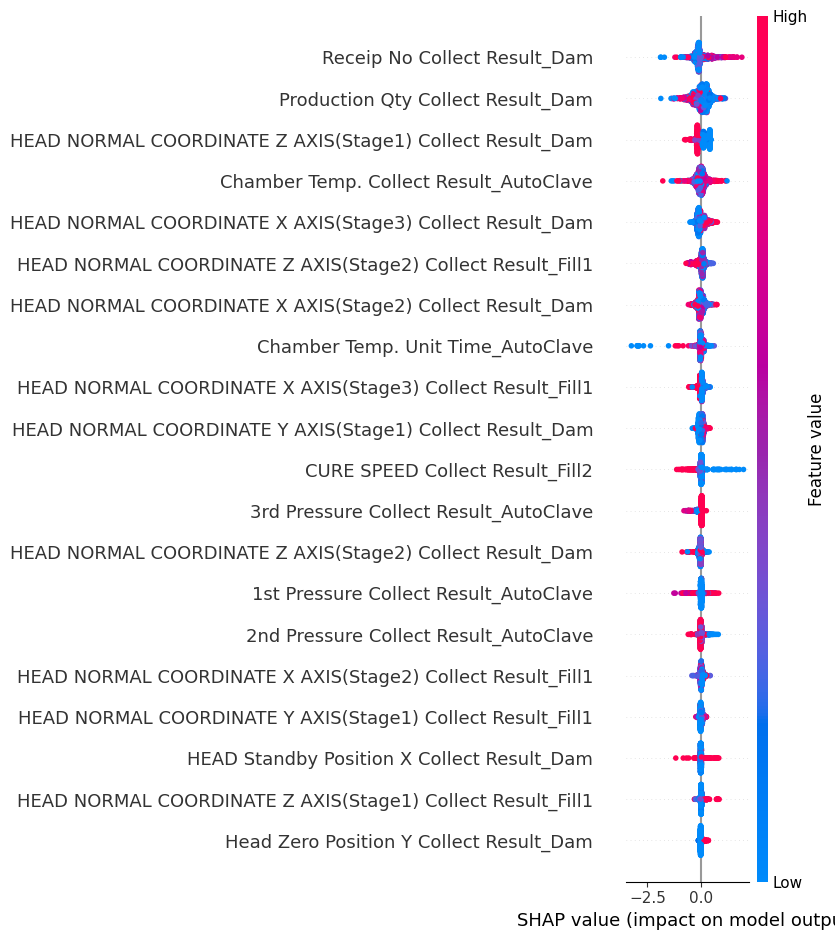

In [62]:
# SHAP 값 계산을 위한 explainer 생성
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

# SHAP 값 시각화 (각 피처의 중요도)
shap.summary_plot(shap_values, X_val)

In [63]:
# 5. SHAP 중요도를 기반으로 피처 선택
# SHAP 값의 절대값 평균을 구하여 중요도를 평가ㅏ
shap_importance = pd.DataFrame({
    'feature': X_val.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

In [64]:
# 중요 피처 기준 설정 (예: 상위 20개 피처만 선택)
threshold = 70
important_features = shap_importance['feature'].head(threshold).tolist()

In [65]:
# 중요 피처만을 선택하여 새로운 데이터셋 생성
X_train_selected = X_train[important_features]
X_val_selected = X_val[important_features]

## 모델 학습 및 평가

여기서 하이퍼 파라미터는 GPU 돌려서 가장 잘 나오는 하이퍼파리미터로 선정했다.

0823_Leem_GPU 참조
* 이후 모델 성능 높인후 마지막에 한번 더 최적의 성능을 만드는 하이퍼파라미터 골라야함


In [66]:
# 선택된 피처로 모델 재학습
model_selected = xgb.XGBClassifier(
    colsample_bytree=0.8,
    gamma=0.1,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=1,
    n_estimators=200,
    reg_alpha=0.1,
    reg_lambda=1,
    subsample=0.8,
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    enable_categorical=True
)
model_selected.fit(X_train_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=110, ...)

### 검증데이터로 평가

In [67]:
# ordianl 인코딩
y_pred_original = model.predict(X_val)
accuracy_original = accuracy_score(y_val, y_pred_original)
report_original = classification_report(y_val, y_pred_original)
f1_score_class_original = f1_score(y_val, y_pred_original, average='binary', pos_label=0)
print(f"Validation Accuracy (Original): {accuracy_original:.4f}")
print(f"F1 Score for Class (Original):                    {f1_score_class_original:.4f}")
print("Classification Report (Original):")
print(report_original)

Validation Accuracy (Original): 0.5883
F1 Score for Class (Original):                    0.5903
Classification Report (Original):
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       725
           1       0.59      0.58      0.59       725

    accuracy                           0.59      1450
   macro avg       0.59      0.59      0.59      1450
weighted avg       0.59      0.59      0.59      1450



In [68]:
# target 인코딩
y_pred_original = model.predict(X_val)
accuracy_original = accuracy_score(y_val, y_pred_original)
report_original = classification_report(y_val, y_pred_original)
f1_score_class_original = f1_score(y_val, y_pred_original, average='binary', pos_label=0)
print(f"Validation Accuracy (Original): {accuracy_original:.4f}")
print(f"F1 Score for Class (Original):                    {f1_score_class_original:.4f}")
print("Classification Report (Original):")
print(report_original)

Validation Accuracy (Original): 0.5883
F1 Score for Class (Original):                    0.5903
Classification Report (Original):
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       725
           1       0.59      0.58      0.59       725

    accuracy                           0.59      1450
   macro avg       0.59      0.59      0.59      1450
weighted avg       0.59      0.59      0.59      1450



# 여기서 부터는 Feature 선택이후

In [69]:
# 피처 선택 후 # ordianl 인코딩
y_pred_selected = model_selected.predict(X_val_selected)
accuracy_selected = accuracy_score(y_val, y_pred_selected)
f1_score_class_0 = f1_score(y_val, y_pred_selected, average='binary', pos_label=0)
report_selected = classification_report(y_val, y_pred_selected)
print(f"Validation Accuracy (Selected Features): {accuracy_selected:.4f}")
print(f"F1 Score for Class 0:                    {f1_score_class_0:.4f}")
print("Classification Report (Selected Features):")
print(report_selected)

Validation Accuracy (Selected Features): 0.6097
F1 Score for Class 0:                    0.6020
Classification Report (Selected Features):
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       725
           1       0.61      0.63      0.62       725

    accuracy                           0.61      1450
   macro avg       0.61      0.61      0.61      1450
weighted avg       0.61      0.61      0.61      1450



In [70]:
# 피처 선택 후 target 인코딩
y_pred_selected = model_selected.predict(X_val_selected)
accuracy_selected = accuracy_score(y_val, y_pred_selected)
f1_score_class_0 = f1_score(y_val, y_pred_selected, average='binary', pos_label=0)
report_selected = classification_report(y_val, y_pred_selected)
print(f"Validation Accuracy (Selected Features): {accuracy_selected:.4f}")
print(f"F1 Score for Class 0:                    {f1_score_class_0:.4f}")
print("Classification Report (Selected Features):")
print(report_selected)

Validation Accuracy (Selected Features): 0.6097
F1 Score for Class 0:                    0.6020
Classification Report (Selected Features):
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       725
           1       0.61      0.63      0.62       725

    accuracy                           0.61      1450
   macro avg       0.61      0.61      0.61      1450
weighted avg       0.61      0.61      0.61      1450



### 5. 최종 예측 및 제출파일 제출

In [71]:
# 4. submission.csv 파일 불러오기
submission = pd.read_csv('submission.csv')

In [72]:
# 10. 최종 모델 선택 후 테스트 데이터 예측
# 중요 피처를 이용해 테스트 데이터셋을 필터링
X_test_selected = test_data_encoded[important_features]

# 모델을 사용해 예측 수행
y_test_pred = model_selected.predict(X_test_selected)

# 11. 예측 결과를 'target' 열로 추가
target_map = {0: 'Normal', 1: 'AbNormal'}
y_test_pred_mapped = pd.Series(y_test_pred).map(target_map)

In [73]:
# 5. 예측 결과를 'target' 열에 넣기
submission['target'] = y_test_pred_mapped

In [74]:
# 6. 결과를 확인하고 저장하기 (옵션)
submission.to_csv('submission.csv', index=False)

In [75]:
submission['target'].value_counts()

target
AbNormal    10402
Normal       6959
Name: count, dtype: int64

###Ordinal Encoding은 데이터에 순서가 있는 경우 간단하고 해석 가능한 방법으로 유용합니다. 그러나 순서 간의 간격이 균등하다고 가정하기 때문에 모델이 이를 정확히 반영하지 못할 수 있습니다.

###Target Encoding은 범주형 변수와 목표 변수 간의 관계를 반영하므로 성능이 향상될 수 있습니다. 그러나 과적합과 데이터 누수의 위험이 있으며, 인코딩 과정이 복잡할 수 있습니다.

# ordinal 인코딩 0.17583030979626013

# target 인코딩 0.17344934044344654